In [1]:
import numpy as np
import copy
import numpy.ma as ma
import csv
import nimfa  # non-negative matrix factorization

#functions
def save_approx(name_of_the_list, approx, i):
    if i == 1 or i == 2 or i == 3 or i==4:  # save approx for rank 1, rank 2 and rank 3
        name_of_the_list.append(approx)
        
import sys
sys.path.append("..")
import utils as ut
import distance_correlation as dc
import STMF as stmf  # sparse tropical matrix factorization

/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


In [2]:
m = 200  # number of rows, 200
n = 100  # number of columns, 100
rank = 3  # rank
missing_value = 0  # 99 is better than 0, because 0 can be the real value in data; 0 because of nmf!
A = ma.masked_array(np.random.rand(m, rank), mask=np.zeros((m, rank)))  # uniform distribution over [0, 1)
B = ma.masked_array(np.random.rand(n, rank), mask=np.zeros((n, rank)))
temp = 21  # 21
repeat = 10  # 10
max_iter = 500
sparsity = 0.2  # 20%
init = 'nndsvd'  # random, random_c, random_vcol, nndsvd
init_tmf = 'random_vcol'

X_maxplus_orig = ut.max_plus(A, B.T)
ut.check_zeros(X_maxplus_orig)
# polo clustering
X_maxplus_orig, row_perm, col_perm = ut.polo_clustering(X_maxplus_orig) # [0] returns matrix, [1] and [2] returns permutations
X_maxplus = copy.deepcopy(X_maxplus_orig)

X_maxplus = ut.create_matrix_with_missing_values(X_maxplus, sparsity, missing_value)  # create matrix with missing values
X_missing_values = copy.deepcopy(X_maxplus)
X_maxplus = ma.masked_equal(X_maxplus, missing_value)  # create masked array
#X_maxplus /= X_maxplus.sum()

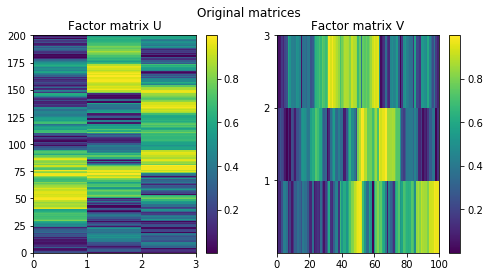

In [3]:
# original factor matrices 
ut.plot_U_V_diff_scales(A[row_perm], B.T[:, col_perm], "Original matrices", "results/rank_4/original_factors.png")

In [4]:
# NMF
errors_nmf_maxplus, corr_nmf_maxplus, rmse_nmf = np.array([]), np.array([]), np.array([])
approx_nmf_maxplus = []
U_nmf, V_nmf = 0, 0
for i in range(1, temp):
    #print("rank " + str(i))
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    for j in range(0, repeat):
        model = nimfa.Nmf(X_maxplus, rank=i, max_iter=max_iter, seed=init)
        nmf = model()
        approx = np.dot(nmf.basis(), nmf.coef(idx=None))
        if i == 4:  # rank 3, all approximations of rank 3 are the same since nndsvd is non-randomized
            U_nmf = nmf.basis()
            V_nmf = nmf.coef(idx=None) 
        error_iter = np.append(error_iter, ut.rmse(X_maxplus_orig, X_missing_values, approx, missing_value))
        rmse_iter = np.append(rmse_iter, ut.rmse_approx(X_maxplus_orig, X_missing_values, approx, missing_value))
        correlation, a, b = dc.dcor(X_maxplus_orig, approx)
        corr_iter = np.append(corr_iter, correlation)
        correlations.append(correlation)
        approximations.append(approx)
    save_approx(approx_nmf_maxplus, approximations[np.argmax(correlations)], i)
    errors_nmf_maxplus, corr_nmf_maxplus, rmse_nmf = np.append(errors_nmf_maxplus, error_iter), np.append(corr_nmf_maxplus, corr_iter), np.append(rmse_nmf, rmse_iter)

# STMF
errors_trop_maxplus, corr_trop_maxplus, rmse_trop = np.array([]), np.array([]), np.array([])
approx_trop_maxplus = []
factor_U, factor_V = [], []
U_stmf, V_stmf = 0, 0
for i in range(1, temp):
    #print("rank " + str(i))
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    for j in range(0, repeat):
        model = stmf.STMF(rank=i, criterion='iterations', max_iter=max_iter, initialization=init_tmf)
        model.fit(X_maxplus)
        if i == 4:
            factor_U.append(model.U)
            factor_V.append(model.V)
        approx = model.predict_all()
        error_iter = np.append(error_iter, ut.rmse(X_maxplus_orig, X_missing_values, approx, missing_value))
        rmse_iter = np.append(rmse_iter, ut.rmse_approx(X_maxplus_orig, X_missing_values, approx, missing_value))
        correlation, a, b = dc.dcor(X_maxplus_orig, approx)
        corr_iter = np.append(corr_iter, correlation)
        correlations.append(correlation)
        approximations.append(approx)
    save_approx(approx_trop_maxplus, approximations[np.argmax(correlations)], i)
    if i == 4:
        U_stmf, V_stmf = factor_U[np.argmax(correlations)], factor_V[np.argmax(correlations)]
    errors_trop_maxplus, corr_trop_maxplus, rmse_trop =  np.append(errors_trop_maxplus, error_iter), np.append(corr_trop_maxplus, corr_iter), np.append(rmse_trop, rmse_iter)

### VISUALIZATIONS

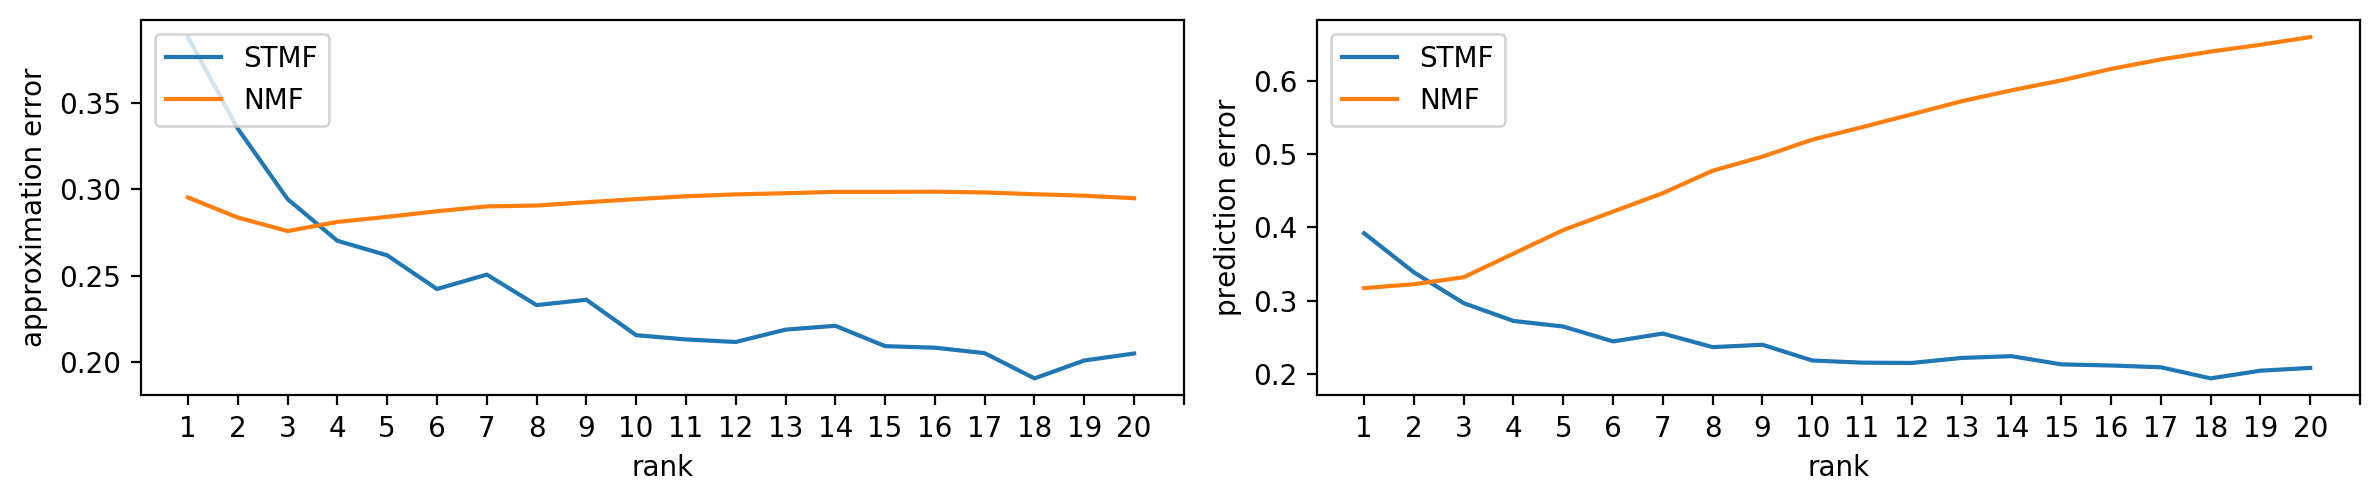

In [5]:
ut.plot_errors_twenty(ut.create_dict(rmse_trop), ut.create_dict(rmse_nmf), ut.create_dict(errors_trop_maxplus), ut.create_dict(errors_nmf_maxplus), '', temp, "results/rank_4/approx_pred.png")

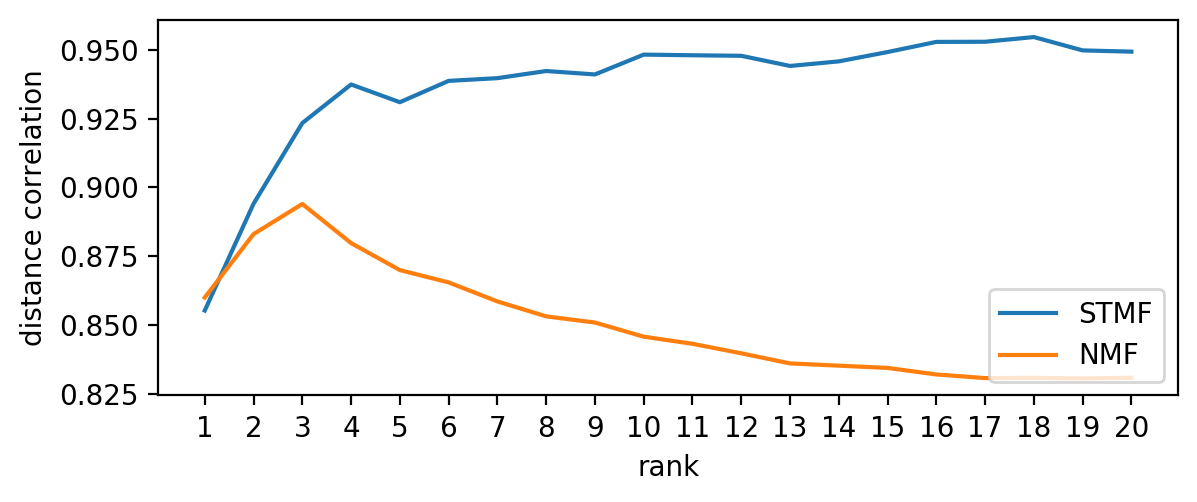

In [6]:
ut.plot_corr_twenty(ut.create_dict(corr_trop_maxplus), ut.create_dict(corr_nmf_maxplus), '', temp, "results/rank_4/corr.png", "distance correlation")

Approximation matrices

In [7]:
approx_stmf = approx_trop_maxplus[3]
approx_nmf = approx_nmf_maxplus[3]

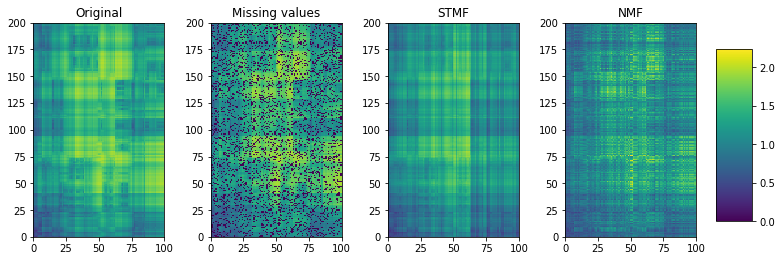

In [8]:
ut.plot_original_missing_trop_nmf_one_colorbar(X_maxplus_orig, X_maxplus, approx_stmf, approx_nmf, "", "results/rank_4/original_missing_approx_one_colorbar.png")

Factor matrices of rank 4

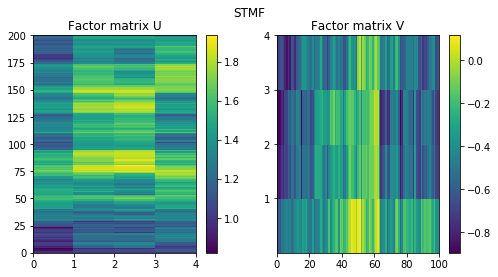

In [9]:
 ut.plot_U_V_diff_scales_four(U_stmf, V_stmf, "STMF", "results/rank_4/factors_STMF.png")

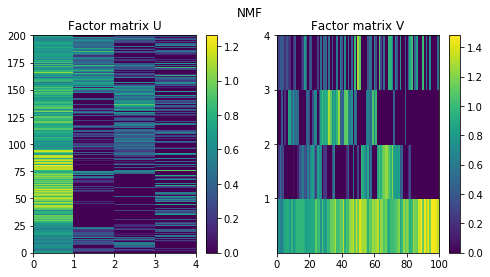

In [10]:
U_nmf, V_nmf = np.array(U_nmf), np.array(V_nmf)
ut.plot_U_V_diff_scales_four(U_nmf, V_nmf, "NMF", "results/rank_4/factors_NMF.png")

Latent matrices STMF

In [11]:
# latent matrix 1
x = U_stmf[:,0].reshape((m, 1))
y = V_stmf[0,:].reshape((1, n))
approx_rank_1 = np.add(x, y)

# latent matrix 2
x = U_stmf[:,1].reshape((m, 1))
y = V_stmf[1,:].reshape((1, n))
approx_rank_2 = np.add(x, y)

# latent matrix 3
x = U_stmf[:,2].reshape((m, 1))
y = V_stmf[2,:].reshape((1, n))
approx_rank_3 = np.add(x, y)

# latent matrix 4
x = U_stmf[:,3].reshape((m, 1))
y = V_stmf[3,:].reshape((1, n))
approx_rank_4 = np.add(x, y)

In [12]:
# binary matrices
approx_rank_1_binary = (approx_rank_1 == approx_stmf)
approx_rank_2_binary = (approx_rank_2 == approx_stmf)
approx_rank_3_binary = (approx_rank_3 == approx_stmf)
approx_rank_4_binary = (approx_rank_4 == approx_stmf)

# real values
approx_rank_1_real = np.ma.masked_array(approx_rank_1, mask=np.logical_not(approx_rank_1_binary))
approx_rank_2_real = np.ma.masked_array(approx_rank_2, mask=np.logical_not(approx_rank_2_binary))
approx_rank_3_real = np.ma.masked_array(approx_rank_3, mask=np.logical_not(approx_rank_3_binary))
approx_rank_4_real = np.ma.masked_array(approx_rank_4, mask=np.logical_not(approx_rank_4_binary))

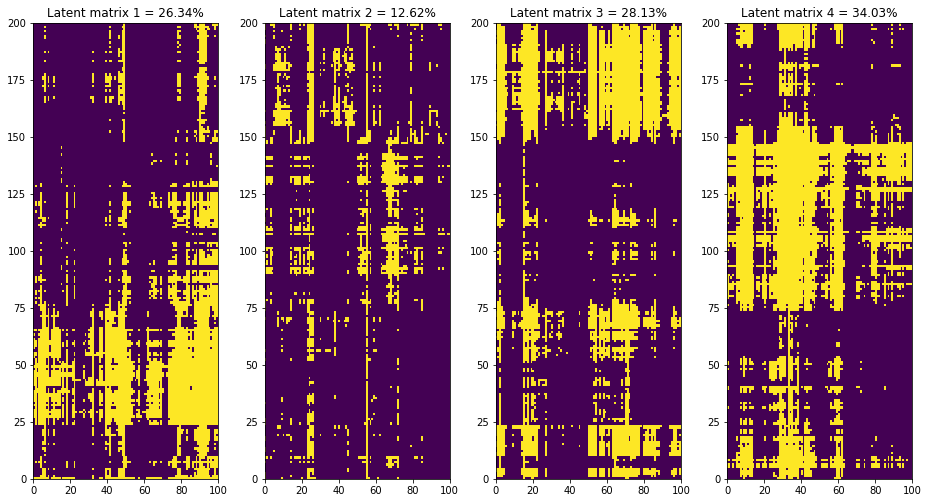

In [13]:
ut.plot_latent_binary_four(approx_rank_1_binary, approx_rank_2_binary, approx_rank_4_binary, approx_rank_3_binary, 'results/rank_4/latent_stmf_binary.png')

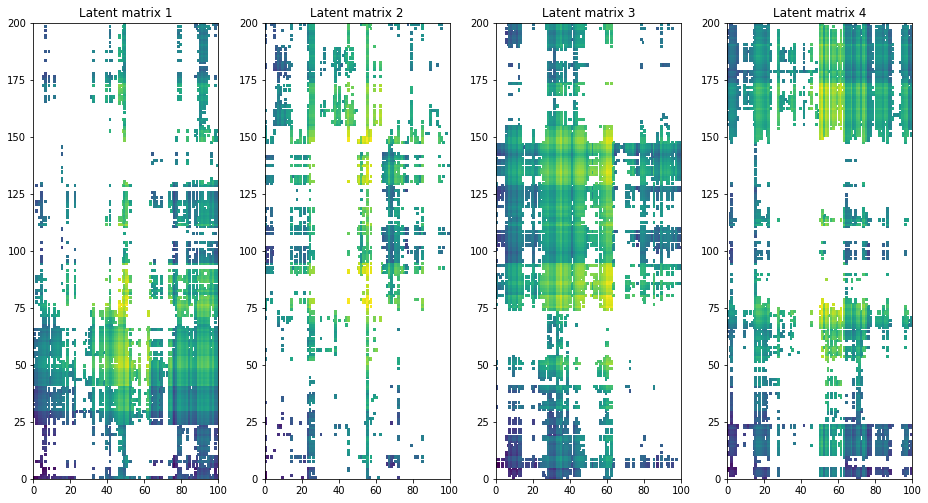

In [14]:
ut.plot_latent_real_four(approx_rank_1_real, approx_rank_2_real, approx_rank_3_real, approx_rank_4_real, 'results/rank_4/latent_stmf_real.png')

Latent matrices NMF

In [15]:
# latent matrix 1
x = U_nmf[:,0].reshape((m, 1))
y = V_nmf[0,:].reshape((1, n))
approx_rank_1 = np.multiply(x, y)

# latent matrix 2
x = U_nmf[:,1].reshape((m, 1))
y = V_nmf[1,:].reshape((1, n))
approx_rank_2 = np.multiply(x, y)

# latent matrix 3
x = U_nmf[:,2].reshape((m, 1))
y = V_nmf[2,:].reshape((1, n))
approx_rank_3 = np.multiply(x, y)

# latent matrix 4
x = U_nmf[:,3].reshape((m, 1))
y = V_nmf[3,:].reshape((1, n))
approx_rank_4 = np.multiply(x, y)

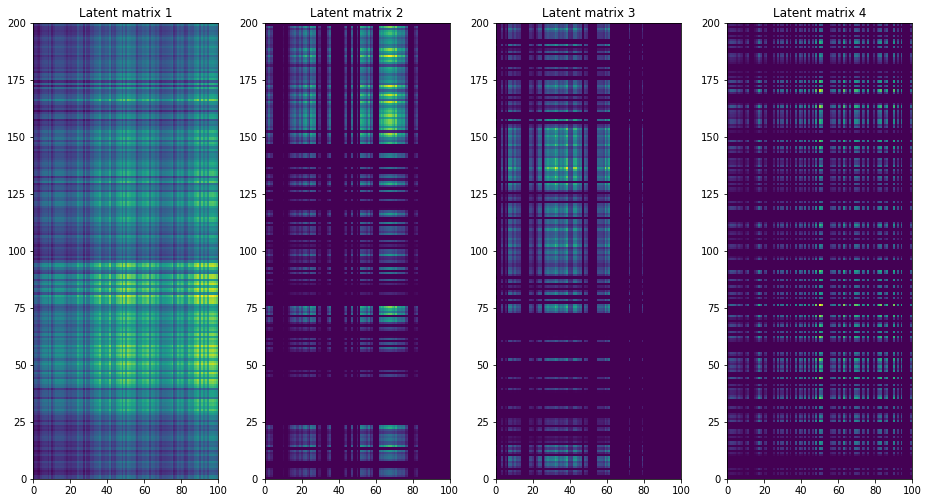

In [16]:
ut.plot_latent_real_four(approx_rank_1, approx_rank_2, approx_rank_3, approx_rank_4, 'results/rank_4/latent_nmf_real.png')

Latent and approximation matrices of STMF and NMF

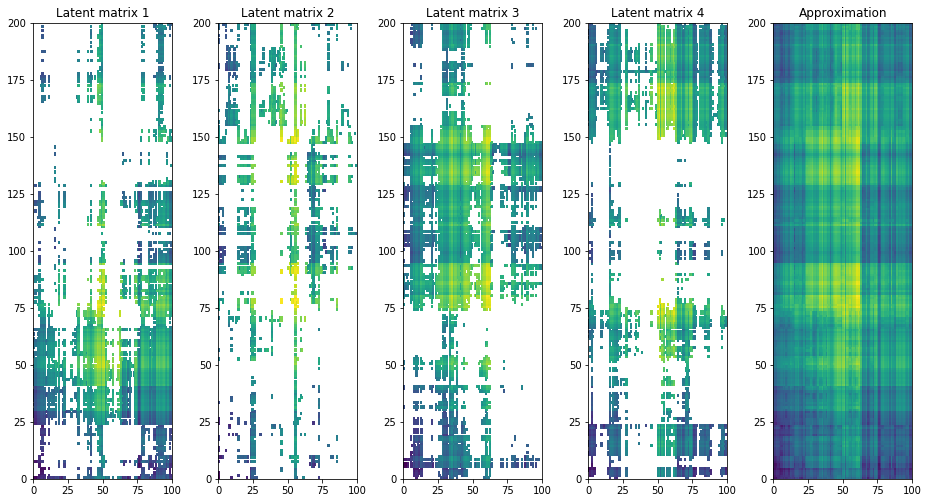

In [17]:
ut.plot_latent_real_approx_four(approx_rank_1_real, approx_rank_2_real, approx_rank_3_real, approx_rank_4_real, np.array(approx_stmf), 'results/rank_4/latent_stmf_real_approx.png')

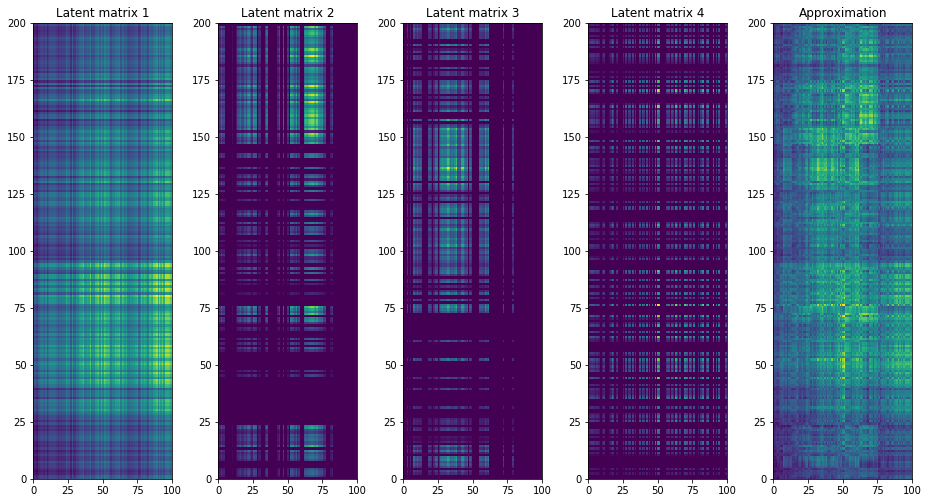

In [18]:
ut.plot_latent_real_approx_four(approx_rank_1, approx_rank_2, approx_rank_3, approx_rank_4, np.array(approx_nmf), 'results/rank_4/latent_nmf_real_approx.png')